In [64]:
pip install datapackage

Note: you may need to restart the kernel to use updated packages.


In [65]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datapackage import Package

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, mean_squared_error as MSE , silhouette_score

from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

pd.options.mode.chained_assignment = None # To avoid set warning messages when I update a dataframe column using the df columns itself

###### Needed installation

In [67]:
pip install flatten_json

Note: you may need to restart the kernel to use updated packages.


##### Main libraries

In [68]:
#basic libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#scrapping libraries

import requests, json
from flatten_json import flatten # to simplify nested json files in pandas df

In [69]:
pd.set_option('max_colwidth', None)

#### ------------------------------------------------------------------------------------------------------

#### Because the season 2020-21 is over there isn't a next round so I will use the last one and I will update the rest of the code when the season 2021-22 begins.

In [70]:
#Retrieving last season

df_odds = pd.read_csv('http://www.football-data.co.uk/mmz4281/2021/SP1.csv', header = 0, usecols = ['HomeTeam', 'AwayTeam','B365H', 'B365D', 'B365A'])
df_odds = df_odds.tail(10)

df_odds.to_excel('coming_round.xlsx')

In [71]:
df_odds

,HomeTeam,AwayTeam,B365H,B365D,B365A
370,Levante,Cadiz,1.75,4.10,4.10
371,Celta,Betis,3.20,3.80,2.10
372,Eibar,Barcelona,4.33,4.75,1.65
373,Elche,Ath Bilbao,1.95,3.60,3.80
374,Huesca,Valencia,1.65,4.20,5.00
375,Osasuna,Sociedad,5.00,4.33,1.61
376,Real Madrid,Villarreal,1.40,5.00,6.50
377,Valladolid,Ath Madrid,9.00,5.25,1.33
378,Granada,Getafe,2.62,3.40,2.60
379,Sevilla,Alaves,1.50,4.33,6.50


#### ------------------------------------------------------------------------------------------------------

#### The following cells will be replaced and updated as soon as the data for the next season is available. This part of the code was intended to retrieve the coming round so it doesn´t work anymore. It will be displayed for academical reasons as ´markdown'.

##### 1) Scrapping upcoming events

#### upcoming events

url = "https://betsapi2.p.rapidapi.com/v1/bet365/upcoming"

querystring = {"sport_id":"1","league_id":"10041110","page":"1"}

headers = {
    'x-rapidapi-key': "aea4b96da0mshe2e45935146cf96p11c6a9jsnc73ba2aae11c",
    'x-rapidapi-host': "betsapi2.p.rapidapi.com"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

###### 1.1) Upcoming events : from json to dataframe

upcoming_events=json.loads(response.text[67:-1])

response_columns = ['id','sport_id','time','time_status','league_id','league_name','home_id','home_name','away_id','away_name','ss','our_event_id','r_id','updated_at']
df_upc_events = pd.DataFrame(columns=response_columns)

for match in upcoming_events:
    match_list = flatten(match)
    df_upc_events = df_upc_events.append(match_list, ignore_index=True)

df_upc_events = df_upc_events.drop(['away_id', 'home_id','league_id','league_name','r_id','ss','time', 'time_status','sport_id','our_event_id','updated_at'], axis = 1)
df_upc_events = df_upc_events[0:10]

df_upc_events

##### 2) Scrapping upcoming events odds

url = "https://betsapi2.p.rapidapi.com/v3/bet365/prematch"

headers = {
    'x-rapidapi-key': "aea4b96da0mshe2e45935146cf96p11c6a9jsnc73ba2aae11c",
    'x-rapidapi-host': "betsapi2.p.rapidapi.com"
    }

df_upc_odds = pd.DataFrame(columns = ['id','1','X','2'])

for i in df_upc_events.id:

    querystring = {"FI":i}
    
    upcoming_odds = requests.request("GET", url, headers=headers, params=querystring)
    
    # turn output into a daframe
    
    upcoming_odds =json.loads(upcoming_odds.text[24:-2])                                    # Fitting the output
    upcoming_odds = flatten(upcoming_odds)

    FI = upcoming_odds.get('FI')
    result_1 = upcoming_odds.get('main_sp_full_time_result_odds_0_odds')                    
    result_X = upcoming_odds.get('main_sp_full_time_result_odds_1_odds')
    result_2 = upcoming_odds.get('main_sp_full_time_result_odds_2_odds')                    # Retrieving key data
    
    list = [FI,result_1,result_X, result_2]       
    a_series = pd.Series(list, index = df_upc_odds.columns)                                 # Gathering key data 
    df_upc_odds = df_upc_odds.append(a_series, ignore_index=True)

upcoming_odds

##### 3) Merging both datasets

df_odds = df_upc_events.merge(df_upc_odds, how = 'left', on = 'id')

#### To match names in the historical dataset

renaming_teams = {'CD Alaves':'Alaves','Athletic Bilbao':'Ath Bilbao','Real Betis':'Betis','Atletico Madrid':'Ath Madrid','Celta Vigo':'Celta','Real Sociedad':'Sociedad'}

df_odds['home_name'].replace(renaming_teams, inplace = True)
df_odds['away_name'].replace(renaming_teams, inplace = True)

df_odds.to_excel('coming_round.xlsx')

#### ------------------------------------------------------------------------------------------------------

#### Creating the dataset with matches, results and odds

In [72]:
package = Package('https://datahub.io/sports-data/spanish-la-liga/datapackage.json')

columns_package = ['Div','Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR','B365H','B365D','B365A']

dictionary_variables = {'Div':'League Division','Date':'Match Date (dd/mm/yy)','Time':'Match Time','HomeTeam':'Home Team','AwayTeam':'Away Team','FTHG':'Full Time Home Team Goals','FTAG':'Full Time Away Team Goals','FTR':'Full Time Result (H Home Win, D Draw, A Away Win)','HS':'Home Team Shots','AS':'Away Team Shots','HST':'Home Team Shots on Target','AST':'Away Team Shots on Target','B365H':'Bet365 home win odds','B365D':'Bet365 draw odds','B365A':'Bet365 away win odds','season':'number of season'}

# Create historical data : season 2009-2010 to 2018-2019

historical_data = pd.DataFrame()

for resource in package.resources:
        if resource.descriptor['datahub']['type'] == 'derived/csv':
            x = pd.DataFrame(data = resource.read())
            x = x.drop(x.columns[range(25,len(x.columns))], axis=1)
            x.columns = columns_package
            x = x.drop(['HTHG','HTAG','HTR','HF','AF','HC','AC','HY','AY','HR','AR'], axis = 1)
            x['season'] = resource.name[7:11]
            historical_data = historical_data.append(x)

In [73]:
# Append season 2019-2020

season_1920 = pd.read_csv('https://www.football-data.co.uk/mmz4281/1920/SP1.csv', header = 0, usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST', 'B365H', 'B365D', 'B365A'])
season_1920['season'] = '1920'
historical_data = historical_data.append(season_1920)

In [74]:
# Current season (2020-2021)

season_2021 = pd.read_csv('http://www.football-data.co.uk/mmz4281/2021/SP1.csv', header = 0, usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST', 'B365H', 'B365D', 'B365A'])
season_2021['season'] = '2021'
historical_data = historical_data.append(season_2021)

# Changing Date type

historical_data['Date'] = pd.to_datetime(historical_data['Date'], dayfirst = True)

#### ------------------------------------------------------------------------------------------------------

#### Because the season 2020-21 is over I will predict the last 10 matches so I need to delete them from the historical_data just created.

In [75]:
historical_data.drop(historical_data.tail(10).index,inplace = True)

#### ------------------------------------------------------------------------------------------------------

In [76]:
historical_data.tail(10)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,B365H,B365D,B365A,season
360,SP1,2021-05-16,Alaves,Granada,4,2,H,14,5,9,2,1.83,3.75,4,2021
361,SP1,2021-05-16,Ath Bilbao,Real Madrid,0,1,A,8,11,1,2,5,4.2,1.6,2021
362,SP1,2021-05-16,Ath Madrid,Osasuna,2,1,H,26,5,9,2,1.22,5.75,15,2021
363,SP1,2021-05-16,Barcelona,Celta,1,2,A,20,4,4,4,1.2,7.5,11,2021
364,SP1,2021-05-16,Betis,Huesca,1,0,H,10,7,2,0,1.75,3.8,4.33,2021
365,SP1,2021-05-16,Cadiz,Elche,1,3,A,7,20,3,5,3.2,3.1,2.35,2021
366,SP1,2021-05-16,Getafe,Levante,2,1,H,9,5,3,1,1.61,3.8,5.75,2021
367,SP1,2021-05-16,Sociedad,Valladolid,4,1,H,13,19,8,5,1.61,3.75,6,2021
368,SP1,2021-05-16,Valencia,Eibar,4,1,H,9,20,5,8,2.87,3.4,2.37,2021
369,SP1,2021-05-16,Villarreal,Sevilla,4,0,H,12,17,5,5,2.37,3.4,2.87,2021


Now a clasification by season/team and date by date is needed to calculate the trends in terms of points, winning/lossing streaks, goals, shoots,etc.

In [77]:
# Table by season|HomeTeam|Date

aux_table_1 = pd.DataFrame(historical_data.groupby(['season','HomeTeam', 'Date'])['Div'].count()).reset_index()
aux_table_1.drop(columns =['Div'], inplace=True)
aux_table_1.rename(columns={"HomeTeam": "Team"}, inplace = True)
aux_table_1['Home/Away'] = 'H'

# Table by season|AwayTeam|Date
aux_table_2 = pd.DataFrame(historical_data.groupby(['season','AwayTeam', 'Date'])['Div'].count()).reset_index()
aux_table_2.drop(columns =['Div'], inplace=True)
aux_table_2.rename(columns={"AwayTeam": "Team"}, inplace = True)
aux_table_2['Home/Away'] = 'A'

# Table by season|Team|Date
aux_table = aux_table_1.append(aux_table_2)
aux_table.reset_index(inplace=True)
aux_table.drop(columns =['index'], inplace=True)

# Assigning number of match
aux_table.sort_values(by=['season','Team','Date'], ascending = True, inplace = True)
aux_table['match']  = aux_table.groupby(['season', 'Team']).cumcount() + 1

In [78]:
aux_table

,season,Team,Date,Home/Away,match
0,0910,Almeria,2009-08-30,H,1
4440,0910,Almeria,2009-09-13,A,2
1,0910,Almeria,2009-09-20,H,3
4441,0910,Almeria,2009-09-23,A,4
2,0910,Almeria,2009-09-27,H,5
...,...,...,...,...,...
4436,2021,Villarreal,2021-04-25,H,33
4437,2021,Villarreal,2021-05-02,H,34
4438,2021,Villarreal,2021-05-09,H,35
8879,2021,Villarreal,2021-05-13,A,36


Now I will add the information from the historica dataset

In [79]:
# Adding the variables from historical dataset

historical_acc_1 = aux_table.merge(historical_data, how = 'inner', left_on=['Date','Team'], right_on=['Date','HomeTeam'])
historical_acc_2 = aux_table.merge(historical_data, how = 'inner', left_on=['Date','Team'], right_on=['Date','AwayTeam'])
historical_acc = historical_acc_1.append(historical_acc_2)

# Rearranging

historical_acc.sort_values(by=['season_x','Team','Date'], inplace = True)

# Calculation of the points

historical_acc['victory']  = historical_acc['Home/Away'] == historical_acc['FTR'] 
historical_acc['draw'] = historical_acc['FTR'] == 'D'
historical_acc['points'] = (historical_acc['victory']) * 3 + historical_acc['draw']
                           
# Removing useless columns
                           
historical_acc.drop(labels=['HomeTeam','AwayTeam','season_y','victory','draw'], axis = 1, inplace = True)
historical_acc.rename(columns = {'season_x': 'season'}, inplace = True)

In [80]:
historical_acc

,season,Team,Date,Home/Away,match,Div,FTHG,FTAG,FTR,HS,AS,HST,AST,B365H,B365D,B365A,points
0,0910,Almeria,2009-08-30,H,1,SP1,0,0,D,20,7,5,1,2.1,3.3,3.5,1
0,0910,Almeria,2009-09-13,A,2,SP1,1,0,H,16,7,4,0,2.38,3.25,3,0
1,0910,Almeria,2009-09-20,H,3,SP1,1,0,H,11,23,3,11,2.5,3.25,2.8,3
1,0910,Almeria,2009-09-23,A,4,SP1,2,2,D,24,12,9,7,1.44,4.33,7,1
2,0910,Almeria,2009-09-27,H,5,SP1,2,2,D,13,13,4,6,2.25,3.25,3.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4436,2021,Villarreal,2021-04-25,H,33,SP1,1,2,A,10,15,4,5,4.5,4.2,1.66,0
4437,2021,Villarreal,2021-05-02,H,34,SP1,1,0,H,4,15,3,3,2.1,2.9,4.1,3
4438,2021,Villarreal,2021-05-09,H,35,SP1,2,4,A,16,11,7,6,1.95,3.6,3.8,0
4439,2021,Villarreal,2021-05-13,A,36,SP1,0,2,A,11,9,2,3,3.8,3.5,1.95,3


In the same way I calculated the points I will calculate the Goals/Shots/Shots in Target

In [81]:
# Calculation of the goals/shots/shots on target

historical_acc['in_home']  = historical_acc['Home/Away'] == 'H'
historical_acc['away_game']  = historical_acc['Home/Away'] == 'A'

# For

historical_acc['goals_for'] = (historical_acc['in_home'] * historical_acc['FTHG']) + (historical_acc['away_game'] * historical_acc['FTAG'])
historical_acc['shots_for'] = (historical_acc['in_home'] * historical_acc['HS']) + (historical_acc['away_game'] * historical_acc['AS'])
historical_acc['shots_target_for'] = (historical_acc['in_home'] * historical_acc['HST']) + (historical_acc['away_game'] * historical_acc['AST'])

# Against

historical_acc['goals_against'] = (historical_acc['in_home'] * historical_acc['FTAG']) + (historical_acc['away_game'] * historical_acc['FTHG'])
historical_acc['shots_against'] = (historical_acc['in_home'] * historical_acc['AS']) + (historical_acc['away_game'] * historical_acc['HS'])
historical_acc['shots_target_against'] = (historical_acc['in_home'] * historical_acc['AST']) + (historical_acc['away_game'] * historical_acc['HST'])

# Cleansing

historical_acc.reset_index(inplace = True)
historical_acc.drop(columns=['index','in_home','away_game','FTHG','FTAG','FTR','HS','AS','HST','AST'], inplace = True)
historical_acc = historical_acc[['season','Date','match','Team','Div','goals_for','goals_against','shots_for','shots_against','shots_target_for','shots_target_against','points']]

Calculating accumulated numbers

In [82]:
historical_acc['goals_for_acc'] = historical_acc.groupby(['season','Team'])['goals_for'].cumsum() - historical_acc['goals_for']
historical_acc['goals_against_acc'] = historical_acc.groupby(['season','Team'])['goals_against'].cumsum() - historical_acc['goals_against']
historical_acc['shots_for_acc'] = historical_acc.groupby(['season','Team'])['shots_for'].cumsum() - historical_acc['shots_for']
historical_acc['shots_against_acc'] = historical_acc.groupby(['season','Team'])['shots_against'].cumsum() - historical_acc['shots_against']
historical_acc['shots_target_for_acc'] = historical_acc.groupby(['season','Team'])['shots_target_for'].cumsum() - historical_acc['shots_target_for']
historical_acc['shots_target_against_acc'] = historical_acc.groupby(['season','Team'])['shots_target_against'].cumsum() - historical_acc['shots_target_against']
historical_acc['points_acc'] = historical_acc.groupby(['season','Team'])['points'].cumsum() - historical_acc['points']

Calculating ranking by round for each season

In [83]:
historical_acc['ranking'] = historical_acc.groupby(['season','match'])['points_acc'].rank(method='first', ascending=True).astype('int64')

In terms of future simplicity the column 'match' will be added to historical_data

In [84]:
historical_data = pd.merge(historical_data,historical_acc[['Date','Team','match']],left_on=['Date','HomeTeam'],right_on = ['Date','Team'], how='left')
historical_data = pd.merge(historical_data,historical_acc[['Date','Team','match']],left_on=['Date','AwayTeam'],right_on = ['Date','Team'], how='left',suffixes=('_home','_away'))
historical_data = historical_data[['Div','Date','season','HomeTeam','AwayTeam','match_home','match_away','B365H','B365D','B365A','FTR']]

In [85]:
columns_to_append= ['Date','Team','goals_for_acc','goals_against_acc','shots_for_acc','shots_against_acc','shots_target_for_acc','shots_target_against_acc','points_acc','ranking']

df_to_be_trained_home = historical_data.merge(historical_acc[columns_to_append], how = 'inner', left_on = ['Date','HomeTeam'], right_on =['Date','Team']).iloc[:,[12,13,14,15,16,17,18,19]]
df_to_be_trained_home = df_to_be_trained_home.add_suffix('_home')

df_to_be_trained_away = historical_data.merge(historical_acc[columns_to_append], how = 'inner', left_on = ['Date','AwayTeam'], right_on =['Date','Team']).iloc[:,[12,13,14,15,16,17,18,19]]
df_to_be_trained_away = df_to_be_trained_away.add_suffix('_away')


df_to_be_trained_aux = pd.concat([historical_data,df_to_be_trained_home,df_to_be_trained_away], axis = 1)
df_to_be_trained_aux.rename(columns={'FTR':'result','match_home':'match'}, inplace = True)

The final dataset to be trained will be the accumulated figures difference between the teams of that match at the time of the match

In [86]:
for col in df_to_be_trained_aux.columns:
    if col[-5:]  == '_home' and col[0:5] != 'match':
        df_to_be_trained_aux[col[:-5]]= df_to_be_trained_aux[col] - df_to_be_trained_aux[col[:-5]+'_away']
        df_to_be_trained_aux.drop(columns=col, axis = 1, inplace = True)
        
    elif col[-5:] =='_away' and col[0:4] != 'Team':
        
        df_to_be_trained_aux.drop(columns=col, axis = 1, inplace = True)
            
# Setting the difference in the classification df_to_be_trained_aux['ranking'] = df_to_be_trained_aux['ranking'] * - 1

In [87]:
columns = ['Div','season','match','HomeTeam','AwayTeam','goals_for_acc','goals_against_acc', 'shots_for_acc', 'shots_against_acc','shots_target_for_acc', 'shots_target_against_acc', 'points_acc','ranking','result','B365H','B365D','B365A']
final_dataset = df_to_be_trained_aux[columns]

In [88]:
final_dataset.tail()

,Div,season,match,HomeTeam,AwayTeam,goals_for_acc,goals_against_acc,shots_for_acc,shots_against_acc,shots_target_for_acc,shots_target_against_acc,points_acc,ranking,result,B365H,B365D,B365A
4435,SP1,2021,37,Cadiz,Elche,4,-1,52,-47,15,-15,13,7,A,3.2,3.1,2.35
4436,SP1,2021,37,Getafe,Levante,-17,-11,-22,-140,-24,-52,-6,-3,H,1.61,3.8,5.75
4437,SP1,2021,37,Sociedad,Valladolid,22,-14,66,-135,35,-49,25,13,H,1.61,3.75,6
4438,SP1,2021,37,Valencia,Eibar,18,5,-40,171,7,31,9,6,H,2.87,3.4,2.37
4439,SP1,2021,37,Villarreal,Sevilla,3,13,-45,52,19,2,-19,-2,H,2.37,3.4,2.87


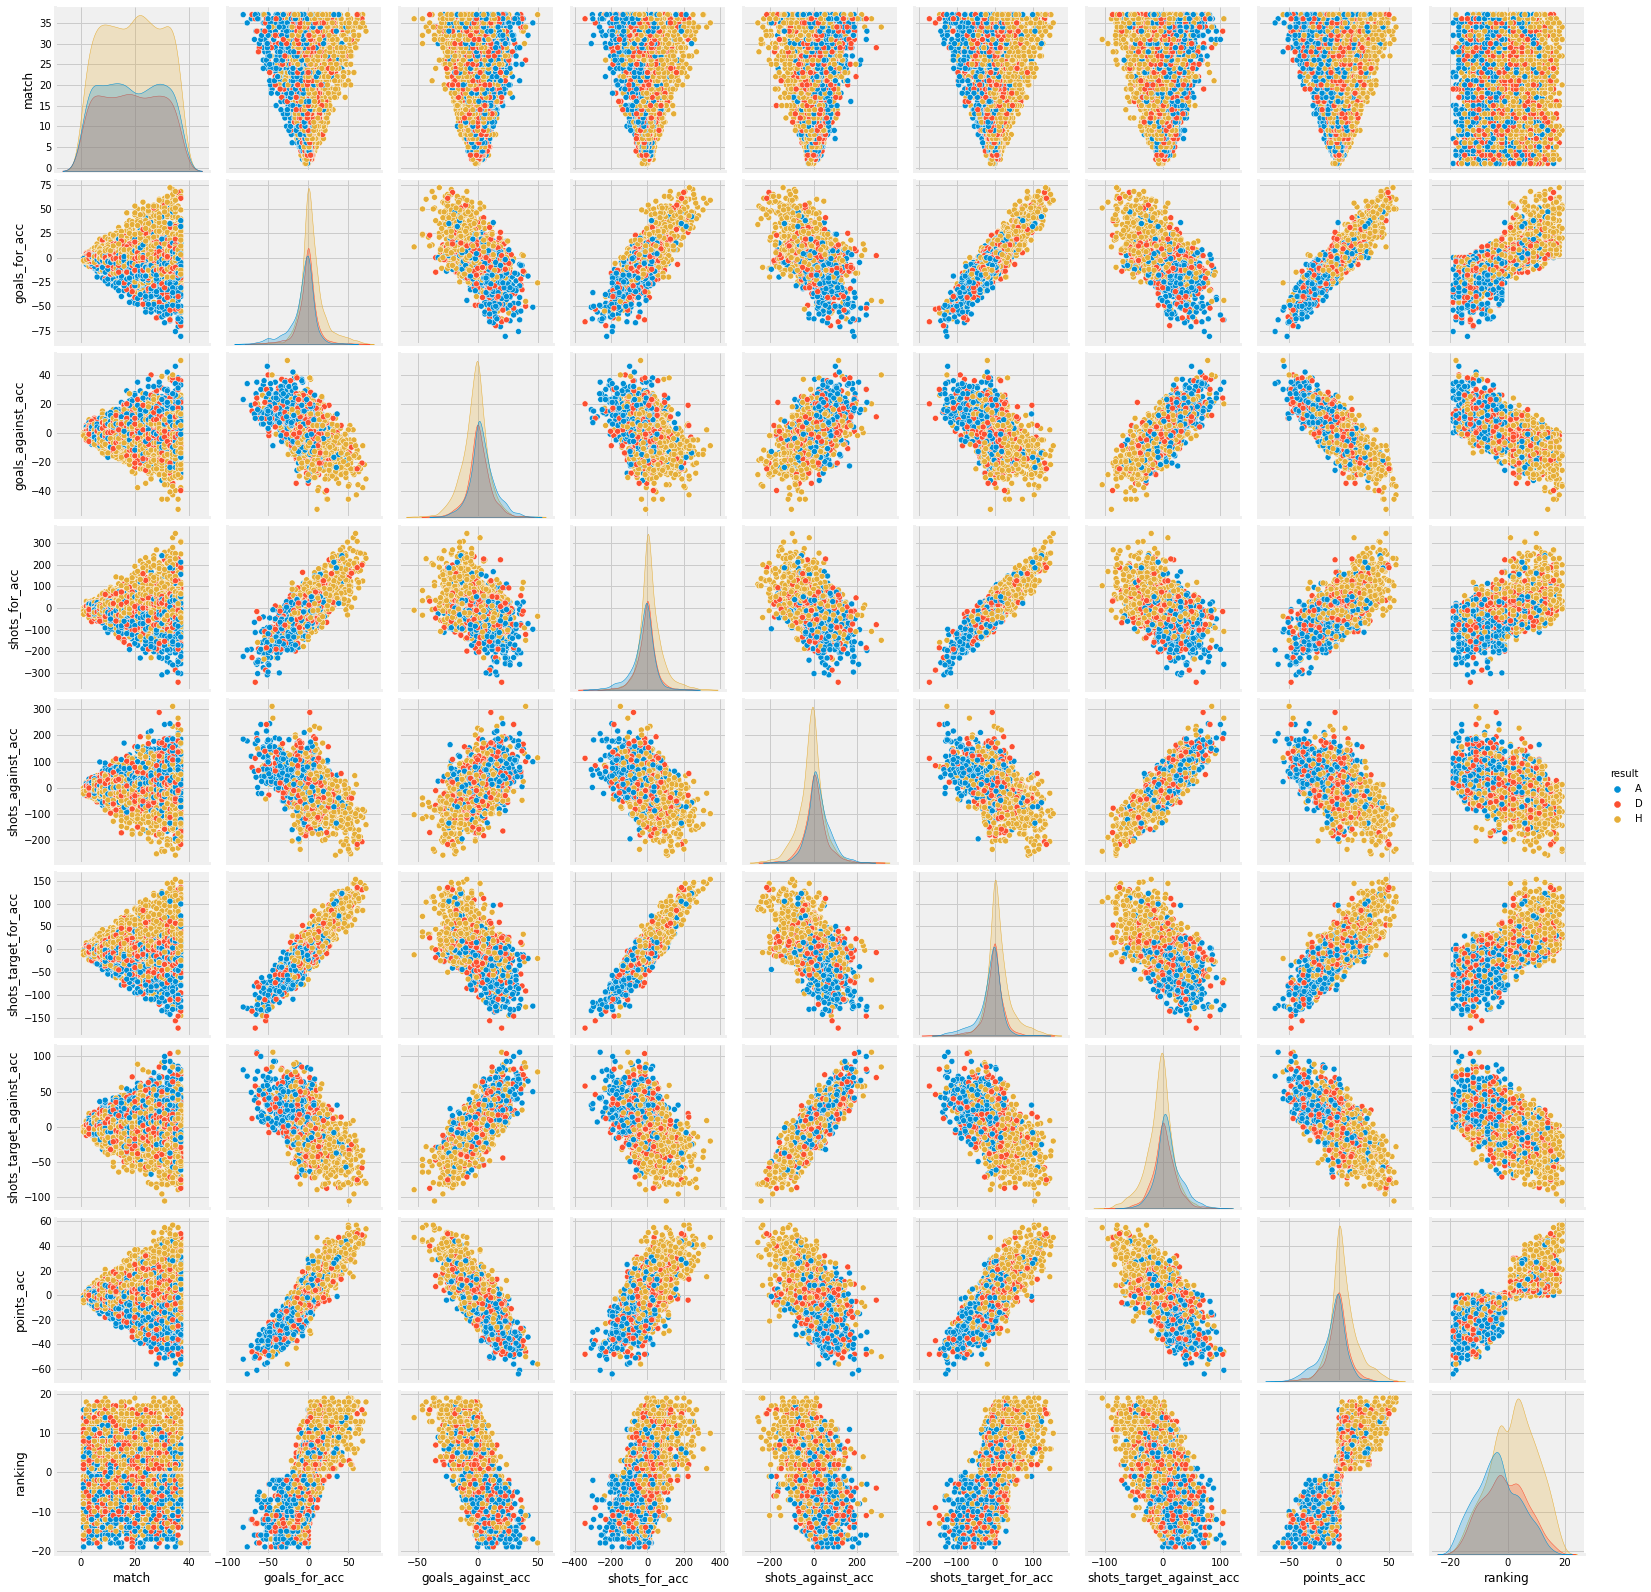

In [89]:
sns.pairplot(final_dataset.iloc[:,1:14], hue='result');

1) Not surprisingly negative ranking values ( ranking of the home team minus the ranking the of the away team just before the game is played) are mostly home victories.
    
 2) Draws don't follow a clear pattern
    

#### PREPARING THE DATASET TO APPLY ML MODELS TO IT

##### PREPARING ENCONDING METHODS

In [90]:
lab_enc_teams = LabelEncoder()
lab_enc_results = LabelEncoder()
hot_enc_teams = OneHotEncoder()
teams_encoded = lab_enc_teams.fit_transform(historical_acc.Team.unique())
results_encoded = lab_enc_results.fit_transform(['H','D','A'])

In [91]:
final_dataset['HomeCode'] = lab_enc_teams.fit_transform(final_dataset[["HomeTeam"]].values.reshape(-1,))
final_dataset['AwayCode'] = lab_enc_teams.fit_transform(final_dataset[["AwayTeam"]].values.reshape(-1,))
final_dataset['result_code'] = lab_enc_results.fit_transform(final_dataset[['result']].values.reshape(-1,))

##### CHANGING SOME VARIABLES TYPES

In [92]:
# Fitting some format variables

categories = ['Div','season','HomeTeam','AwayTeam','result']

floats = ['B365H','B365D','B365A']

integers = ['season']


# Categories 

for item in categories:
    final_dataset[item] = final_dataset[item].astype('category')
    
# floats

for item in floats:
    final_dataset[item] = final_dataset[item].astype('float')
    
# integers

for item in integers:
    final_dataset[item] = final_dataset[item].astype('int64')

##### SPLITTING DATASET

In [93]:
scaler = StandardScaler()

features = final_dataset.select_dtypes('integer').iloc[:,:-1]
                                
target = final_dataset['result_code']

#Training regular dataset 

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state = 13)

#Normalized X_train and X_test datasetsdar

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.iloc[:,:-2]), columns = X_train.columns[:-2]) # I exclude Home and Away Team before  applying Standard Scaler
X_test_scaled = pd.DataFrame(scaler.transform(X_test.iloc[:,:-2]), columns = X_test.columns[:-2])
features_scaled = pd.DataFrame(scaler.transform(features.iloc[:,:-2]), columns = features.columns[:-2])

##### KMEANS - ARE THERE SIMILAR MATCHES ? 

I will work on identying similar kind of matches by KMeans to check later if accuracy is better for one or some of these clusters.

In [94]:
 kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,
}
    
sse = []

for k in range(1,20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train_scaled)
    sse.append(kmeans.inertia_)

In [95]:
# A list holds the silhouette coefficients for each 

silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train_scaled)
    score = silhouette_score(X_train_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

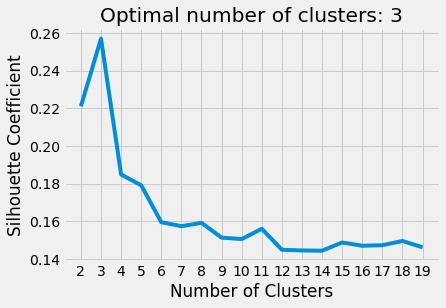

In [96]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Optimal number of clusters: '+ str(silhouette_coefficients.index(max(silhouette_coefficients))+2))
plt.show()

#### First look at different models

In [97]:
# Set seed for reproducibility
SEED=1

# Instantiate lr
lr = LogisticRegression(max_iter=10000)

# Instate dtc

dtc = DecisionTreeClassifier(random_state=SEED)

# Instantiate knn
knn = KNeighborsClassifier()

# Instantiate lda

lda = LinearDiscriminantAnalysis(solver='svd')

# Instantiate gnb

gnb = GaussianNB()

#Instantiate svc

svc = SVC()

#Instantiate rfc

rfc = RandomForestClassifier(random_state=SEED)

# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('DecisionTreeClassifier',dtc), ('K Nearest Neighbours', knn), ('LinearDiscriminantAnalysis', lda),('GaussianNB',gnb),('SVC',svc),('RandomForestClassifier',rfc)]

In [98]:
# Iterate over the pre-defined list of classifiers
model_list = []
scaled_list = []
accuracy_list = []
cross_val_score_mean = []

# Fit clf to the training set

for clf_name, clf in classifiers:    
 
    clf.fit(X_train, y_train)
    
    model_list.append(clf_name)
    scaled_list.append(0)
    
    # Predict y_pred
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) 
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    
    accuracy_list.append(np.round(accuracy,decimals=2))
    cross_val_score_mean.append(np.round(sum(scores)/len(scores),decimals=2))
    
#Evaluate clf's accuracy on scaled train dataset

for clf_name, clf in classifiers:    
 
    # Fit clf to the training set
    clf.fit(X_train_scaled, y_train)
    
    model_list.append(clf_name)
    scaled_list.append(1)
    
    # Predict y_pred
    y_pred = clf.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) 
    
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=10)
    accuracy_list.append(np.round(accuracy, decimals=2))
    cross_val_score_mean.append(np.round(sum(scores)/len(scores), decimals=2))
    
final_scoring_list = pd.DataFrame(np.column_stack([model_list, scaled_list, accuracy_list, cross_val_score_mean]), columns=['model', 'scaled', 'accuracy','mean_score_value'])
final_scoring_list['accuracy'] = pd.to_numeric(final_scoring_list['accuracy'])

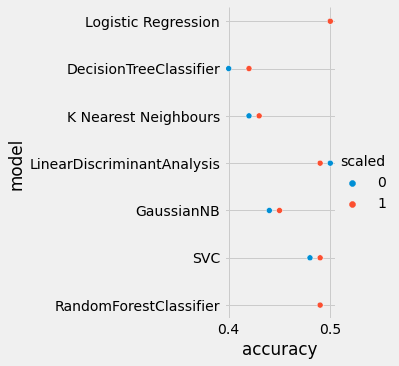

In [99]:
sns.relplot(
    data=final_scoring_list,
    x="accuracy", y="model",
    hue="scaled"
);

Better to use scaled dataset for models based on distances and the regular one on the decision tree ones. GausssianNB & KNN will be dismissed.

##### A) Decision Tree Classifier

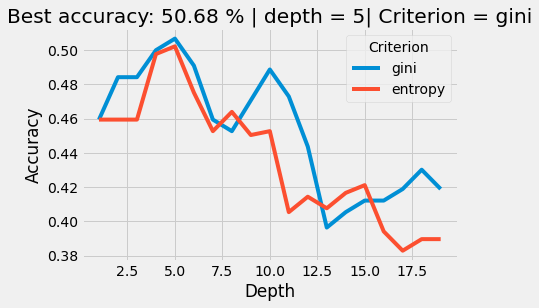

In [100]:
max_depth = 1
criterion = ['gini','entropy']
max_depth_results = []
criterion_results = []
accuracy_results = []

while max_depth <20:
    
    for item in criterion:
        dtc = DecisionTreeClassifier(criterion=item, max_depth=max_depth, random_state=1)
        dtc = dtc.fit(X_train, y_train)
        predictions = dtc.predict(X_test)
        max_depth_results.append(max_depth)
        criterion_results.append(item)
        accuracy_results.append(metrics.accuracy_score(y_test,predictions))
        
    max_depth +=1

total_results = pd.DataFrame(list(zip(max_depth_results, criterion_results, accuracy_results)),columns=['Depth','Criterion','Accuracy'])

dtc_max_acc = total_results[total_results['Accuracy'] == total_results.Accuracy.max()]

sns.lineplot(x="Depth", y="Accuracy",
             hue="Criterion",
             data=total_results).set_title('Best accuracy: ' + str(np.round(dtc_max_acc.iloc[0,2]  * 100, 2)) + ' % | depth = ' + str(dtc_max_acc.iloc[0,0]) +'| Criterion = '+ dtc_max_acc.iloc[0,1]);

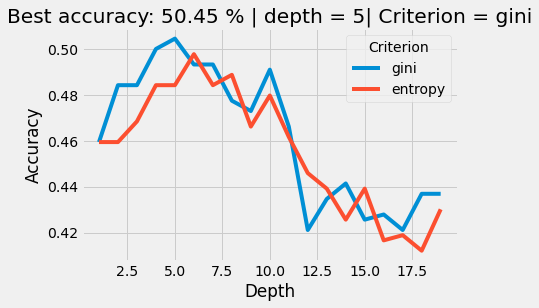

In [101]:
max_depth = 1
criterion = ['gini','entropy']
max_depth_results = []
criterion_results = []
accuracy_results = []

while max_depth <20:
    
    for item in criterion:
        dtc = DecisionTreeClassifier(criterion=item, max_depth=max_depth, random_state=1)
        dtc = dtc.fit(X_train_scaled, y_train)
        predictions_scaled = dtc.predict(X_test_scaled)
        max_depth_results.append(max_depth)
        criterion_results.append(item)
        accuracy_results.append(metrics.accuracy_score(y_test,predictions_scaled))
        
    max_depth +=1

total_results = pd.DataFrame(list(zip(max_depth_results, criterion_results, accuracy_results)),columns=['Depth','Criterion','Accuracy'])

dtc_max_acc = total_results[total_results['Accuracy'] == total_results.Accuracy.max()]

sns.lineplot(x="Depth", y="Accuracy",
             hue="Criterion",
             data=total_results).set_title('Best accuracy: ' + str(np.round(dtc_max_acc.iloc[0,2]  * 100, 2)) + ' % | depth = ' + str(dtc_max_acc.iloc[0,0]) +'| Criterion = '+ dtc_max_acc.iloc[0,1]);

###### Applying model with the best parameters

In [102]:
dtc = DecisionTreeClassifier(criterion='gini',max_depth=2, random_state=1)
dtc.fit(X_train, y_train)
predictions_dtc = dtc.predict(X_test)
predictions_prob_dtc = dtc.predict_proba(X_test)
predictions_dtc_all = dtc.predict(features)
predictions_prob_dtc_all = dtc.predict_proba(features)

##### Decision Tree Classifier - Features

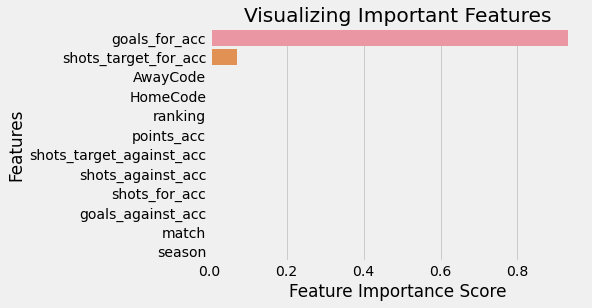

In [103]:
feature_imp = pd.Series(dtc.feature_importances_,index=X_train.columns).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show();

#### B) Random Forest Classifier

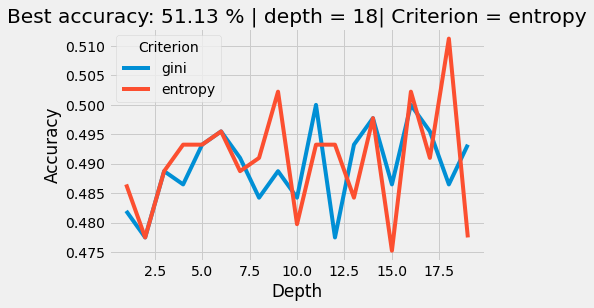

In [104]:
max_depth = 1
criterion = ['gini','entropy']
max_depth_results = []
criterion_results = []
accuracy_results = []

while max_depth <20:
    
    for item in criterion:
        rfc = RandomForestClassifier(criterion=item, max_depth=max_depth, random_state=1)
        rfc = rfc.fit(X_train, y_train)
        predictions = rfc.predict(X_test)
        max_depth_results.append(max_depth)
        criterion_results.append(item)
        accuracy_results.append(metrics.accuracy_score(y_test,predictions))
        
    max_depth +=1

total_results = pd.DataFrame(list(zip(max_depth_results, criterion_results, accuracy_results)),columns=['Depth','Criterion','Accuracy'])

rfc_max_acc = total_results[total_results['Accuracy'] == total_results.Accuracy.max()]

sns.lineplot(x="Depth", y="Accuracy",
             hue="Criterion",
             data=total_results).set_title('Best accuracy: ' + str(np.round(rfc_max_acc.iloc[0,2]  * 100, 2)) + ' % | depth = ' + str(rfc_max_acc.iloc[0,0]) +'| Criterion = '+ rfc_max_acc.iloc[0,1]);

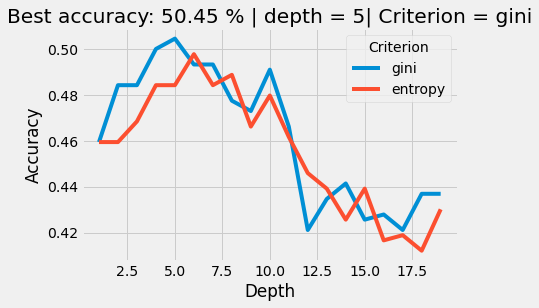

In [105]:
max_depth = 1
criterion = ['gini','entropy']
max_depth_results = []
criterion_results = []
accuracy_results = []

while max_depth <20:
    
    for item in criterion:
        rfc = DecisionTreeClassifier(criterion=item, max_depth=max_depth, random_state=1)
        rfc = rfc.fit(X_train_scaled, y_train)
        predictions_scaled = rfc.predict(X_test_scaled)
        max_depth_results.append(max_depth)
        criterion_results.append(item)
        accuracy_results.append(metrics.accuracy_score(y_test,predictions_scaled))
        
    max_depth +=1

total_results = pd.DataFrame(list(zip(max_depth_results, criterion_results, accuracy_results)),columns=['Depth','Criterion','Accuracy'])

rfc_max_acc = total_results[total_results['Accuracy'] == total_results.Accuracy.max()]

sns.lineplot(x="Depth", y="Accuracy",
             hue="Criterion",
             data=total_results).set_title('Best accuracy: ' + str(np.round(rfc_max_acc.iloc[0,2]  * 100, 2)) + ' % | depth = ' + str(rfc_max_acc.iloc[0,0]) +'| Criterion = '+ rfc_max_acc.iloc[0,1]);

##### Applying model with the best parameters

In [106]:
rfc = RandomForestClassifier(criterion='gini',max_depth=6, random_state=1)
rfc.fit(X_train, y_train)
predictions_rfc = rfc.predict(X_test)
predictions_prob_rfc = rfc.predict_proba(X_test)
predictions_rfc_all = rfc.predict(features)
predictions_prob_rfc_all = rfc.predict_proba(features)

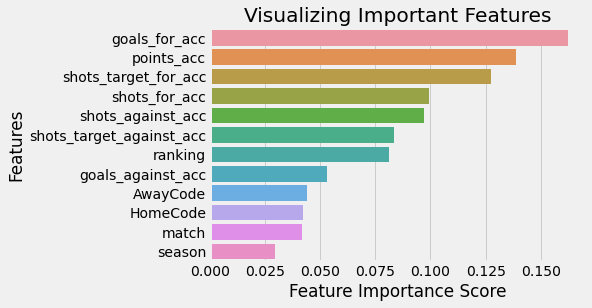

In [107]:
feature_imp = pd.Series(rfc.feature_importances_,index=X_train.columns).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

#### C) Logistic Regression

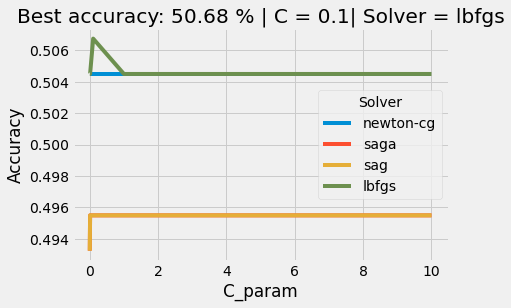

In [108]:
C_param_range = [0.001,0.01,0.1,1,10]
solver = ['newton-cg','saga','sag','lbfgs']
C_param_result = []
solver_results = []
accuracy_results = []


for i in C_param_range:
    
    for item in solver:
        
        lr = LogisticRegression(penalty='l2',solver=item, multi_class = 'multinomial', max_iter=10000,random_state=42,C=i)
        lr = lr.fit(X_train, y_train)
        predictions = lr.predict(X_test)
        C_param_result.append(i)
        solver_results.append(item)
        accuracy_results.append(metrics.accuracy_score(y_test,predictions))
        

total_results = pd.DataFrame(list(zip(C_param_result,solver_results, accuracy_results)),columns=['C_param','Solver','Accuracy'])

lr_max_acc = total_results[total_results['Accuracy'] == total_results.Accuracy.max()]

sns.lineplot(x="C_param", y="Accuracy",
             hue="Solver",
             data=total_results).set_title('Best accuracy: ' + str(np.round(lr_max_acc.iloc[0,2]  * 100, 2)) + ' % | C = ' + str(lr_max_acc.iloc[0,0]) +'| Solver = '+ lr_max_acc.iloc[0,1]);

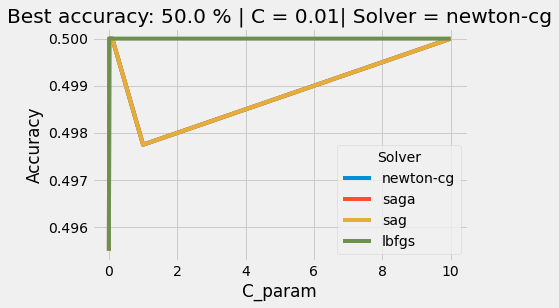

In [109]:
C_param_range = [0.001,0.01,0.1,1,10]
solver = ['newton-cg','saga','sag','lbfgs']
C_param_result = []
solver_results = []
accuracy_results = []


for i in C_param_range:
    
    for item in solver:
        
        lr = LogisticRegression(penalty='l2',solver=item, multi_class = 'multinomial', max_iter=10000,random_state=42,C=i)
        lr = lr.fit(X_train_scaled, y_train)
        predictions_scaled = lr.predict(X_test_scaled)
        C_param_result.append(i)
        solver_results.append(item)
        accuracy_results.append(metrics.accuracy_score(y_test,predictions_scaled))
        

total_results = pd.DataFrame(list(zip(C_param_result,solver_results, accuracy_results)),columns=['C_param','Solver','Accuracy'])

lr_max_acc = total_results[total_results['Accuracy'] == total_results.Accuracy.max()]

sns.lineplot(x="C_param", y="Accuracy",
             hue="Solver",
             data=total_results).set_title('Best accuracy: ' + str(np.round(lr_max_acc.iloc[0,2]  * 100, 2)) + ' % | C = ' + str(lr_max_acc.iloc[0,0]) +'| Solver = '+ lr_max_acc.iloc[0,1]);

##### Applying model with the best parameters

In [110]:
lr = LogisticRegression(penalty='l2',solver='newton-cg', multi_class = 'multinomial', max_iter=10000,random_state=42,C=0.001)
lr = lr.fit(X_train, y_train)
predictions_lr = lr.predict(X_test)
predictions_prob_lr = lr.predict_proba(X_test)
predictions_lr_all = lr.predict(features)
predictions_prob_lr_all = lr.predict_proba(features)

#### D) K-Neighbors Classifier

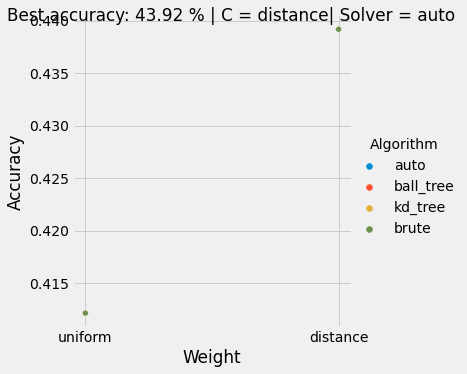

In [111]:
weights = ['uniform','distance']
algorithm = ['auto','ball_tree','kd_tree','brute']
weights_results = []
algorithm_results = []
accuracy_results = []


for i in weights:
    
    for item in algorithm:
        
        knc = KNeighborsClassifier(n_neighbors=3,weights=i,algorithm = item)
        knc = knc.fit(X_train, y_train)
        predictions = knc.predict(X_test)
        weights_results.append(i)
        algorithm_results.append(item)
        accuracy_results.append(metrics.accuracy_score(y_test,predictions))
        

total_results = pd.DataFrame(list(zip(weights_results,algorithm_results, accuracy_results)),columns=['Weight','Algorithm','Accuracy'])

knc_max_acc = total_results[total_results['Accuracy'] == total_results.Accuracy.max()]

knc_plot = sns.relplot(x="Weight", y="Accuracy",
             hue="Algorithm",
             data=total_results)

knc_plot.fig.suptitle('Best accuracy: ' + str(np.round(knc_max_acc.iloc[0,2]  * 100, 2)) + ' % | C = ' + str(knc_max_acc.iloc[0,0]) +'| Solver = '+ knc_max_acc.iloc[0,1]);



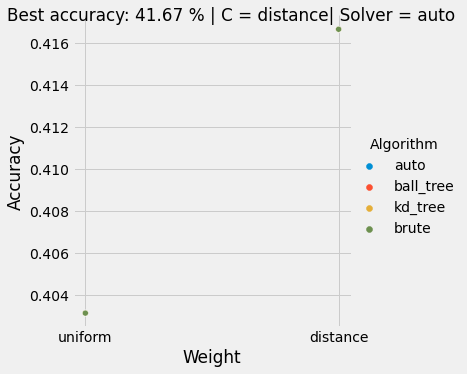

In [112]:
weights = ['uniform','distance']
algorithm = ['auto','ball_tree','kd_tree','brute']
weights_results = []
algorithm_results = []
accuracy_results = []


for i in weights:
    
    for item in algorithm:
        
        knc = KNeighborsClassifier(n_neighbors=3,weights=i,algorithm = item)
        knc = knc.fit(X_train_scaled, y_train)
        predictions_scaled = knc.predict(X_test_scaled)
        weights_results.append(i)
        algorithm_results.append(item)
        accuracy_results.append(metrics.accuracy_score(y_test,predictions_scaled))
        

total_results = pd.DataFrame(list(zip(weights_results,algorithm_results, accuracy_results)),columns=['Weight','Algorithm','Accuracy'])

knc_max_acc = total_results[total_results['Accuracy'] == total_results.Accuracy.max()]

knc_plot = sns.relplot(x="Weight", y="Accuracy",
             hue="Algorithm",
             data=total_results)

knc_plot.fig.suptitle('Best accuracy: ' + str(np.round(knc_max_acc.iloc[0,2]  * 100, 2)) + ' % | C = ' + str(knc_max_acc.iloc[0,0]) +'| Solver = '+ knc_max_acc.iloc[0,1]);

This model won't be considered for having an accuracy 7pp lower than the previous ones

#### E) Linear Discriminant Analysis

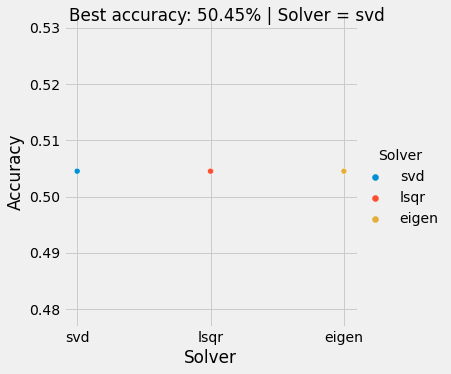

In [113]:
solvers = ['svd','lsqr','eigen']
solvers_results = []
accuracy_results = []

    
for item in solvers:
        
    lda = LinearDiscriminantAnalysis(solver = item)
    lda = lda.fit(X_train, y_train)
    predictions = lda.predict(X_test)
    solvers_results.append(item)
    accuracy_results.append(metrics.accuracy_score(y_test,predictions))

total_results = pd.DataFrame(list(zip(solvers_results, accuracy_results)),columns=['Solver','Accuracy'])

lda_max_acc = total_results[total_results['Accuracy'] == total_results.Accuracy.max()]

lda_plot = sns.relplot(x="Solver", y="Accuracy",
             hue="Solver",
             data=total_results)
lda_plot.fig.suptitle('Best accuracy: ' + str(np.round(lda_max_acc.iloc[0,1]  * 100, 2)) +'% | Solver = '+ lda_max_acc.iloc[0,0]);



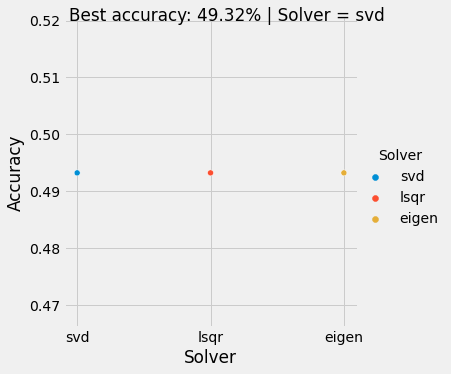

In [114]:
solvers = ['svd','lsqr','eigen']
solvers_results = []
accuracy_results = []

    
for item in solvers:
        
    lda = LinearDiscriminantAnalysis(solver = item)
    lda = lda.fit(X_train_scaled, y_train)
    predictions_scaled = lda.predict(X_test_scaled)
    solvers_results.append(item)
    accuracy_results.append(metrics.accuracy_score(y_test,predictions_scaled))

total_results = pd.DataFrame(list(zip(solvers_results, accuracy_results)),columns=['Solver','Accuracy'])

lda_max_acc = total_results[total_results['Accuracy'] == total_results.Accuracy.max()]

lda_plot = sns.relplot(x="Solver", y="Accuracy",
             hue="Solver",
             data=total_results)

lda_plot.fig.suptitle('Best accuracy: ' + str(np.round(lda_max_acc.iloc[0,1]  * 100, 2)) +'% | Solver = '+ lda_max_acc.iloc[0,0]);

##### Applying model with the best parameters

In [115]:
lda = LinearDiscriminantAnalysis(solver='svd')
lda = lda.fit(X_train, y_train)
predictions_lda = lda.predict(X_test)
predictions_prob_lda = lda.predict_proba(X_test)
predictions_lda_all = lda.predict(features)
predictions_prob_lda_all = lda.predict_proba(features)

#### F) SVC

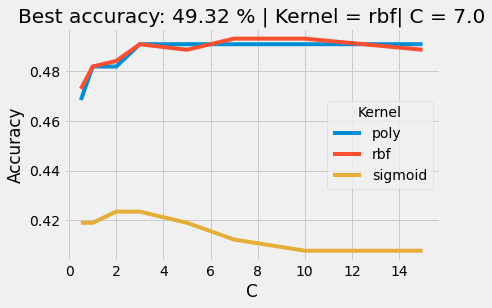

In [116]:
kernel = ['poly', 'rbf', 'sigmoid']
c_list = [0.5,1.0,2.0,3.0,5.0,7.0,10.0,12.5,15.0]
kernel_results = []
c_results = []
accuracy_results = []


for c in c_list:
    
    for item in kernel:
        
        svc = SVC(kernel = item, C = c)
        svc = svc.fit(X_train, y_train)
        predictions_svc = svc.predict(X_test)
        kernel_results.append(item)
        c_results.append(c)
        accuracy_results.append(metrics.accuracy_score(y_test,predictions_svc))
        

total_results = pd.DataFrame(list(zip(kernel_results, c_results, accuracy_results)),columns=['Kernel','C','Accuracy'])

svc_max_acc = total_results[total_results['Accuracy'] == total_results.Accuracy.max()]

sns.lineplot(x="C", y="Accuracy",hue="Kernel",data=total_results)

plt.title('Best accuracy: ' + str(np.round(svc_max_acc.iloc[0,2]  * 100, 2)) + ' % | Kernel = ' + str(svc_max_acc.iloc[0,0]) +'| C = '+ str(np.round(svc_max_acc.iloc[0,1])));

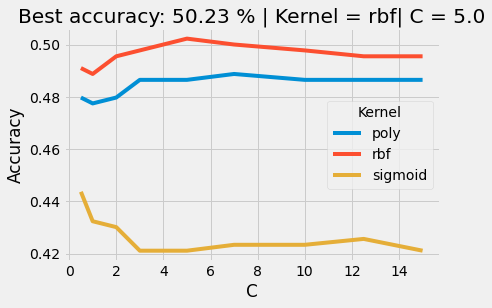

In [117]:
kernel = ['poly', 'rbf', 'sigmoid']
c_list = [0.5,1.0,2.0,3.0,5.0,7.0,10.0,12.5,15.0]
kernel_results = []
c_results = []
accuracy_results = []


for c in c_list:
    
    for item in kernel:
        
        svc = SVC(kernel = item, C = c)
        svc = svc.fit(X_train_scaled, y_train)
        predictions_svc = svc.predict(X_test_scaled)
        kernel_results.append(item)
        c_results.append(c)
        accuracy_results.append(metrics.accuracy_score(y_test,predictions_svc))
        

total_results = pd.DataFrame(list(zip(kernel_results, c_results, accuracy_results)),columns=['Kernel','C','Accuracy'])

svc_max_acc = total_results[total_results['Accuracy'] == total_results.Accuracy.max()]

sns.lineplot(x="C", y="Accuracy",hue="Kernel",data=total_results)

plt.title('Best accuracy: ' + str(np.round(svc_max_acc.iloc[0,2]  * 100, 2)) + ' % | Kernel = ' + str(svc_max_acc.iloc[0,0]) +'| C = '+ str(np.round(svc_max_acc.iloc[0,1])));

##### Applying model with the best parameters

In [118]:
svc = SVC(kernel = 'rbf', C = 7.0, probability=True)
svc = svc.fit(X_train, y_train)
predictions_svc = svc.predict(X_test)
predictions_prob_svc = svc.predict_proba(X_test)
predictions_svc_all = svc.predict(features)
predictions_prob_svc_all = svc.predict_proba(features)

#### Gathering all the prediction results

In [119]:
# Assigning clusters to the dataset

kmeans = KMeans(n_clusters= 3 ,**kmeans_kwargs)
kmeans.fit(X_train_scaled)
k_predictions = kmeans.predict(X_test_scaled)
k_predictions_all = kmeans.predict(features_scaled)

In [120]:
# Defining a dictionary with the best ML models

models = {'dtc':[predictions_dtc_all,predictions_prob_dtc_all,dtc], 'rfc':[predictions_rfc_all, predictions_prob_rfc_all,rfc], 'lr':[predictions_lr_all,predictions_prob_lr_all,lr],'lda':[predictions_lda_all,predictions_prob_lda_all,lda],'svc':[predictions_svc_all, predictions_prob_svc_all,svc]}

# Applying these models to the whole dataset

final_dataset_fin = pd.DataFrame()
    
for model in models:
    
    final_dataset_aux = historical_data.copy()
    final_dataset_aux['cluster'] = k_predictions_all
    final_dataset_aux['Prob_Home%'] = np.round(models[model][1][:,2]*100,2)
    final_dataset_aux['Prob_Draw%'] = np.round(models[model][1][:,1]*100,2)
    final_dataset_aux['Prob_Away%'] = np.round(models[model][1][:,0]*100,2)
    final_dataset_aux['Prediction'] = models[model][0]
    final_dataset_aux['Prediction'] = lab_enc_results.inverse_transform(final_dataset_aux['Prediction'])
    final_dataset_aux['hit_result'] = (final_dataset_aux['FTR'] == final_dataset_aux['Prediction'])*1
    final_dataset_aux['paid_quota'] = ((final_dataset_aux['FTR'] == 'A') * final_dataset_aux['B365A']) + ((final_dataset_aux['FTR'] == 'D') * final_dataset_aux['B365D']) + ((final_dataset_aux['FTR'] == 'H') * final_dataset_aux['B365H'])
    final_dataset_aux['Prize'] = final_dataset_aux['hit_result'] * final_dataset_aux['paid_quota']
    final_dataset_aux['Profit'] =  final_dataset_aux['Prize'] - 1
    final_dataset_aux['Difficulty'] = final_dataset_aux['paid_quota'].astype('int')
    final_dataset_aux['Model'] = model
    final_dataset_fin = final_dataset_fin.append(final_dataset_aux)

In [121]:
# Exporting results

final_dataset_fin.to_excel('user_report/final_dataset_fin.xlsx')

In [122]:
final_dataset_fin.tail()

,Div,Date,season,HomeTeam,AwayTeam,match_home,match_away,B365H,B365D,B365A,...,Prob_Home%,Prob_Draw%,Prob_Away%,Prediction,hit_result,paid_quota,Prize,Profit,Difficulty,Model
4435,SP1,2021-05-16,2021,Cadiz,Elche,37,37,3.2,3.1,2.35,...,55.54,26.90,17.55,H,0,2.35,0,-1,2,svc
4436,SP1,2021-05-16,2021,Getafe,Levante,37,37,1.61,3.8,5.75,...,49.72,27.77,22.51,H,1,1.61,1.61,0.61,1,svc
4437,SP1,2021-05-16,2021,Sociedad,Valladolid,37,37,1.61,3.75,6,...,60.85,29.95,9.20,H,1,1.61,1.61,0.61,1,svc
4438,SP1,2021-05-16,2021,Valencia,Eibar,37,37,2.87,3.4,2.37,...,33.72,29.38,36.89,H,1,2.87,2.87,1.87,2,svc
4439,SP1,2021-05-16,2021,Villarreal,Sevilla,37,37,2.37,3.4,2.87,...,37.51,28.37,34.12,H,1,2.37,2.37,1.37,2,svc


In [123]:
# Importing the coming matchs with the odds

coming_round = pd.read_excel('coming_round.xlsx', names=['id','HomeTeam','AwayTeam','B365H','B365D','B365A'], dtypes = ['int','str','str','float','float','float'])
coming_round.drop(['id'], axis = 1, inplace=True)
coming_round

,HomeTeam,AwayTeam,B365H,B365D,B365A
0,Levante,Cadiz,1.75,4.10,4.10
1,Celta,Betis,3.20,3.80,2.10
2,Eibar,Barcelona,4.33,4.75,1.65
3,Elche,Ath Bilbao,1.95,3.60,3.80
4,Huesca,Valencia,1.65,4.20,5.00
5,Osasuna,Sociedad,5.00,4.33,1.61
6,Real Madrid,Villarreal,1.40,5.00,6.50
7,Valladolid,Ath Madrid,9.00,5.25,1.33
8,Granada,Getafe,2.62,3.40,2.60
9,Sevilla,Alaves,1.50,4.33,6.50


In [124]:
#Current season 
current_season = max(historical_data['season'])

# Filtering historical dataset by current season
historical_acc_current_season = historical_acc[historical_acc['season'] == current_season]

# Calculating the latest match played by each team
historical_acc_current_season_round = historical_acc_current_season.groupby('Team')[['match']].max().reset_index()

# Historical dataset figures at the latest game
historical_acc_current_season_match = historical_acc_current_season_round.merge(historical_acc_current_season, left_on=['Team','match'],right_on=['Team','match'])

# We need to adjust accumulated figures and update classification

historical_acc_current_season_match['goals_for_acc'] = historical_acc_current_season_match['goals_for_acc'] + historical_acc_current_season_match['goals_for']
historical_acc_current_season_match['goals_against_acc'] = historical_acc_current_season_match['goals_against_acc'] + historical_acc_current_season_match['goals_against']
historical_acc_current_season_match['shots_for_acc'] = historical_acc_current_season_match['shots_for_acc'] + historical_acc_current_season_match['shots_for']
historical_acc_current_season_match['shots_against_acc'] = historical_acc_current_season_match['shots_against_acc'] + historical_acc_current_season_match['shots_against']
historical_acc_current_season_match['shots_target_for_acc'] = historical_acc_current_season_match['shots_target_for_acc'] + historical_acc_current_season_match['shots_target_for']
historical_acc_current_season_match['shots_target_against_acc'] = historical_acc_current_season_match['shots_target_against_acc'] + historical_acc_current_season_match['shots_target_against']
historical_acc_current_season_match['points_acc'] = historical_acc_current_season_match['points_acc'] + historical_acc_current_season_match['points']
historical_acc_current_season_match['ranking'] = historical_acc_current_season_match['points_acc'].rank(method='first', ascending=True)

# Merging coming round and accumulated figures

coming_round_home = coming_round.merge(historical_acc_current_season_match[['Div','season','match','Team','goals_for_acc','goals_against_acc','shots_for_acc','shots_against_acc','shots_target_for_acc','shots_target_against_acc','points_acc','ranking']], left_on='HomeTeam', right_on ='Team')
coming_round_away = coming_round.merge(historical_acc_current_season_match[['Div','season','match','Team','goals_for_acc','goals_against_acc','shots_for_acc','shots_against_acc','shots_target_for_acc','shots_target_against_acc','points_acc','ranking']], left_on='AwayTeam', right_on ='Team', suffixes=('','_away'))
coming_round_aux = coming_round_home[['Div','season','match','HomeTeam','AwayTeam','goals_for_acc','goals_against_acc','shots_for_acc','shots_against_acc','shots_target_for_acc','shots_target_against_acc','points_acc','ranking','B365H','B365D','B365A']]

# Adjusting the accumulated numbers

coming_round_aux['HomeCode'] = lab_enc_teams.fit_transform(coming_round_aux[["HomeTeam"]].values.reshape(-1,))
coming_round_aux['AwayCode'] = lab_enc_teams.fit_transform(coming_round_aux[["AwayTeam"]].values.reshape(-1,))
coming_round_aux['goals_for_acc'] = coming_round_aux.loc[:,'goals_for_acc'] - coming_round_away.loc[:,'goals_for_acc']
coming_round_aux['goals_against_acc'] = coming_round_aux['goals_against_acc'] - coming_round_away['goals_for_acc']
coming_round_aux['shots_for_acc'] = coming_round_aux['shots_for_acc'] - coming_round_away['shots_for_acc']
coming_round_aux['shots_against_acc'] = coming_round_aux['shots_against_acc'] - coming_round_away['shots_against_acc']
coming_round_aux['shots_target_for_acc'] = coming_round_aux['shots_target_for_acc'] - coming_round_away['shots_target_for_acc']
coming_round_aux['shots_target_against_acc'] = coming_round_aux['shots_target_against_acc'] - coming_round_away['shots_target_against_acc']
coming_round_aux['points_acc'] = coming_round_aux['points_acc'] - coming_round_away['points_acc']
coming_round_aux['ranking'] = coming_round_aux['ranking'] - coming_round_away['ranking']
coming_round_aux.drop(['Div','HomeTeam','AwayTeam'], axis = 1, inplace = True)

# Changing season & match types

coming_round_aux['season'] = coming_round_aux['season'].astype(int)
coming_round_aux['match'] = (coming_round_aux['match'] +1).astype(int)

# Predicting clusters to the coming matches
                 
coming_round_scaled = pd.DataFrame(scaler.transform(coming_round_aux.iloc[:,0:10]), columns = coming_round_aux.columns[0:10])
coming_round_cluster_predictions = kmeans.predict(coming_round_scaled)

# Final coming round

coming_round_final = coming_round_aux.iloc[:,np.r_[0:10,13,14]]

In [125]:
coming_round_all = pd.DataFrame()

for model in models:
    
    # Calculating predictions and probabilities to the coming matches
    
    coming_round_final = coming_round_aux.iloc[:,np.r_[0:10,13,14]]             
    predictions_coming_round_aux = models[model][2].predict(coming_round_final)
    predictions_coming_round = lab_enc_results.inverse_transform(predictions_coming_round_aux)
    predictions_prob_coming_round = models[model][2].predict_proba(coming_round_final)


    # Adding clusters and probs to the coming matches
                 
    coming_round_final['cluster'] = coming_round_cluster_predictions
    coming_round_final['prediction'] = predictions_coming_round
    coming_round_final['Prob_Home%'] = np.round(predictions_prob_coming_round[:,2]*100,2)
    coming_round_final['Prob_Draw%'] = np.round(predictions_prob_coming_round[:,1]*100,2)
    coming_round_final['Prob_Away%'] = np.round(predictions_prob_coming_round[:,0]*100,2) 
    coming_round_final['model'] = model
    
    # Adding the quotas and teams
    
    bets = coming_round_aux[['B365H','B365D','B365A']]
    teams = coming_round[['HomeTeam','AwayTeam']]
    coming_round_final = pd.concat([coming_round_final,bets, teams], axis = 1)
    
    # Aggregating data
    
    coming_round_all  = coming_round_all.append(coming_round_final)

In [126]:
# Exporting the results

coming_round_all.to_excel('user_report/coming_round_all.xlsx')